In [ ]:
# Install git if not already installed
!apt-get install -q git

# Clone the repository
!git clone https://github.com/niloydebbarma-code/Udacity-Project-2-my-own-image-classifier.git

# Move all files and folders to the /content folder
!mv Udacity-Project-2-my-own-image-classifier/* /content/

# Optional: Remove the now-empty directory
!rm -r Udacity-Project-2-my-own-image-classifier

Reading package lists...
Building dependency tree...
Reading state information...
git is already the newest version (1:2.34.1-1ubuntu1.11).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Cloning into 'Udacity-Project-2-my-own-image-classifier'...
remote: Enumerating objects: 8556, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 8556 (delta 9), reused 24 (delta 0), pack-reused 8498
Receiving objects: 100% (8556/8556), 330.00 MiB | 16.88 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (8201/8201), done.


Use Google Colab

Use T4 GPU

For it Click on the drop-down box - connect
then change runtime type
select T4 GPU
Saved**

In [ ]:
# Import necessary packages
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

import json

from collections import OrderedDict

import time

from PIL import Image

import matplotlib.pyplot as plt

print("Libraries imported successfully.")

Libraries imported successfully.


In [ ]:
# Define directories
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

# Define transforms for the training, validation, and testing sets
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

# Define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=32)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=32)

print("Data loaded successfully.")

Data loaded successfully.


In [ ]:
# Load the mapping from category label to category name
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

print("Category to name mapping loaded successfully.")

Category to name mapping loaded successfully.


In [ ]:
# Load a pre-trained network
model = models.vgg16_bn(pretrained=True)

# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

# Define a new, untrained feed-forward network as a classifier
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(25088, 4096)),
                          ('relu', nn.ReLU()),
                          ('dropout', nn.Dropout(0.2)),
                          ('fc2', nn.Linear(4096, 102)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
model.classifier = classifier

print("Model built successfully.")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:03<00:00, 143MB/s]


Model built successfully.


In [ ]:
# Set the device to GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

epochs = 2
steps = 0
print_every = len(trainloader)  # This ensures the summary is printed once per epoch

for epoch in range(epochs):
    running_loss = 0
    for inputs, labels in trainloader:
        steps += 1

        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)

                    valid_loss += batch_loss.item()

                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/len(trainloader):.3f}.. "
                  f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader) * 100:.2f}%")
            running_loss = 0
            model.train()

print("Training complete.")

Epoch 1/2.. Train loss: 2.415.. Validation loss: 0.610.. Validation accuracy: 83.52%
Epoch 2/2.. Train loss: 0.921.. Validation loss: 0.541.. Validation accuracy: 84.12%
Training complete.


In [ ]:
# Test the network
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    # Assuming 'testloader' is the name of your test dataloader
    for inputs, labels in testloader:  # Replace 'dataloaders['test']' with 'testloader'
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)
        test_loss += batch_loss.item()

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test Loss: {test_loss/len(testloader):.3f}.. "  # Also replace here
      f"Test Accuracy: {accuracy/len(testloader):.3f}")  # And here

Test Loss: 0.489.. Test Accuracy: 0.870


In [ ]:
# Save the checkpoint
# Assuming 'train_data' is the ImageFolder dataset used for training:
model.class_to_idx = train_data.class_to_idx  # Replace 'train_dataset' with the correct variable

checkpoint = {
    'state_dict': model.state_dict(),
    'class_to_idx': model.class_to_idx
}

torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
# Load the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.vgg16(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(25088, 4096)),
        ('relu', nn.ReLU()),
        ('dropout', nn.Dropout(0.5)),
        ('fc2', nn.Linear(4096, 102)),
        ('output', nn.LogSoftmax(dim=1))
    ]))

    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    return model

In [ ]:
def process_image(image_path):
    pil_image = Image.open(image_path)
    pil_image = pil_image.resize((256, 256))
    left = (pil_image.width - 224) / 2
    top = (pil_image.height - 224) / 2
    right = (pil_image.width + 224) / 2
    bottom = (pil_image.height + 224) / 2
    pil_image = pil_image.crop((left, top, right, bottom))
    np_image = np.array(pil_image) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    np_image = np_image.transpose((2, 0, 1))
    return torch.tensor(np_image).float()

def predict(image_path, model, topk=5):
    image = process_image(image_path)
    image = image.unsqueeze(0)
    model.eval()
    with torch.no_grad():
        outputs = model(image)
        ps = torch.nn.functional.softmax(outputs, dim=1)
        top_p, top_class = ps.topk(topk, dim=1)
        idx_to_class = {v: k for k, v in model.class_to_idx.items()}
        top_class = top_class.cpu().numpy()[0]
        top_class = [idx_to_class[i] for i in top_class]
    return top_p.cpu().numpy()[0], top_class

print("Inference function for classification is ready.")

Inference function for classification is ready.


In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    return ax

def plot_solution(image_path, model):
    plt.figure(figsize=(6,10))
    ax = plt.subplot(2,1,1)
    img = process_image(image_path)
    imshow(img, ax, title=cat_to_name[image_path.split('/')[2]])
    probs, classes = predict(image_path, model)
    class_names = [cat_to_name[item] for item in classes]
    plt.subplot(2,1,2)
    sns.barplot(x=probs, y=class_names, color=sns.color_palette()[0])
    plt.show()

print("Prediction display function is ready.")

Prediction display function is ready.


Model is loaded on the device: cuda
Image processed successfully.
Predicted probabilities:  [0.50938237 0.47163555 0.0133827  0.00277444 0.00068779]
Predicted classes:  ['1', '51', '86', '83', '76']


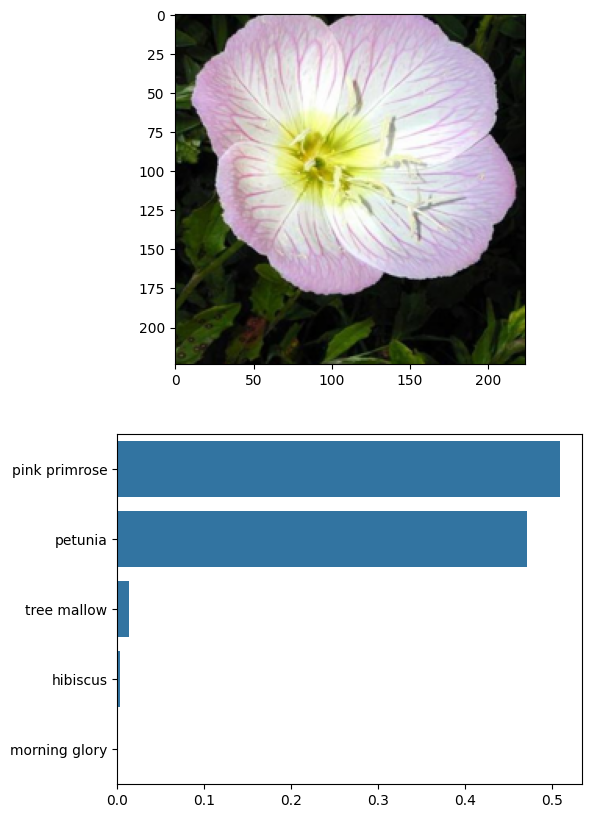

Prediction display completed successfully.


In [ ]:
# Load the model and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("Model is loaded on the device:", device)

# Process and predict
image_path = '/content/flowers/test/1/image_06743.jpg'
img = process_image(image_path)
print("Image processed successfully.")

probs, classes = predict(image_path, model)
print("Predicted probabilities: ", probs)
print("Predicted classes: ", classes)

# Display the result
plot_solution(image_path, model)
print("Prediction display completed successfully.")